In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Introduction: Keynes, Friedman, Modigliani

In [2]:
# Some initial setup

import sys
import os
from matplotlib import pyplot as plt
import numpy as np
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Dark2')
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime as dt
import scipy.stats as stats
import statsmodels.formula.api as sm
from copy  import deepcopy

from HARK.ConsumptionSaving.ConsIndShockModel import *
import HARK.ConsumptionSaving.ConsumerParameters as Params
from HARK.utilities import plotFuncsDer, plotFuncs

### 1. The Keynesian consumption function

Keynes:
1. "The amount of aggregate consumption mainly depends on the amount of aggregate income."
1. "It is a "fundamental psychological rule ... that when ... real income increases ... consumption [will increase], but by less than the increase in income."
1. More generally, "as a rule, a greater proportion of income ... is saved as real income increases."

This can be formalized as:

$
\begin{eqnarray}
c_t & = &  a_0 + a_{1}y_t
\\ c_t - c_{t-1} & = & a_{1}(y_t - y_{t-1})
\end{eqnarray}
$

for $a_0 > 0, a_1 < 1$


#### The Keynesian Consumption Function

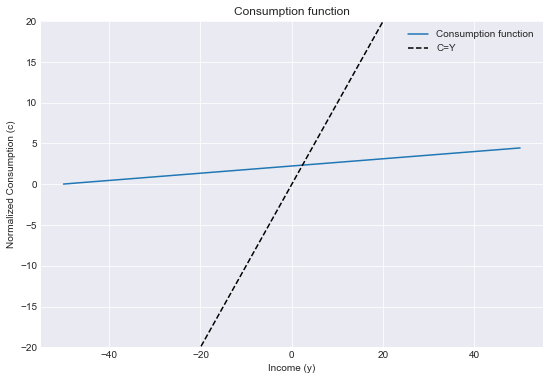

In [3]:
# Plot cFunc(Y)=Y against the Keynesian consumption function
# Deaton-Friedman consumption function is a special case of perfect foresight model
PFexample = PerfForesightConsumerType(**Params.init_perfect_foresight) # set up a consumer type and use default parameteres
PFexample.cycles = 0 # Make this type have an infinite horizon

PFexample.solve() # solve the consumer's problem
PFexample.unpackcFunc() # unpack the consumption function

# Plot the perfect foresight consumption function
income_PF = np.linspace(-50, 50, 20) # pick some income points
plt.figure(figsize=(9,6))
plt.plot(income_PF, PFexample.solution[0].cFunc(income_PF), label = 'Consumption function') #plot income versus the consumption
plt.plot(income_PF, income_PF, 'k--', label = 'C=Y')
plt.title('Consumption function')
plt.xlabel('Income (y)')
plt.ylabel('Normalized Consumption (c)')
plt.ylim(-20, 20)
plt.legend()
plt.show()

In [4]:
# This looks like the first of the three equations, consumption as a linear function of income!
# This means that even in a microfounded model (that HARK provides), the consumption function can match Keynes reduced form
# prediction (given the right parameterisation).

# We can even find a_0 and a_1

a_0 = PFexample.solution[0].cFunc(0)
a_1 = PFexample.solution[0].cFunc(1) - PFexample.solution[0].cFunc(0) # We could also simulate the model in HARK and use MPCnow
print('a_0 is ' + str(a_0))
print('a_1 is ' +  str(a_1))

a_0 is 2.236208063441574
a_1 is 0.04428139169919554


#### The Keynesian consumption function: Evidence

Aggregate Data:

Long-term time-series estimates: $a_0$ close to zero, $a_1$ close to 1 (saving rate stable over time - Kuznets).<br>
Short-term aggregate time-series estimates of change in consumption on change in income find $a_1 << 1$.<br>
$c_t = a_0 + a_{1}y_t + a_{2}c_{t-1}$ finds significant $a_2$, near 1.

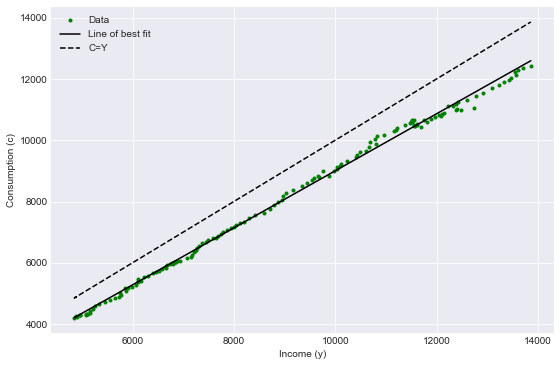

a_0 is -306.43398253080704
a_1 is 0.9308078823782152


In [5]:
# Lets have a look at some aggregate data

sdt = dt.datetime(1980, 1, 1) #set startdate
edt = dt.datetime (2017, 1, 1) #set end date
df = web.DataReader(["PCECC96", "DPIC96"], "fred", sdt, edt) #import the data from Fred

# Plot the data
plt.figure(figsize=(9,6))
plt.plot(df.DPIC96, df.PCECC96, 'go', markersize=3.0, label='Data')
slope, intercept, r_value, p_value, std_err = stats.linregress(df.DPIC96, df.PCECC96)
plt.plot(df.DPIC96, intercept+slope*df.DPIC96, 'k-', label = 'Line of best fit')
plt.plot(df.DPIC96, df.DPIC96, 'k--', label = 'C=Y')
plt.xlabel('Income (y)')
plt.ylabel('Consumption (c)')
plt.legend()
plt.show()

print('a_0 is ' + str(intercept))
print('a_1 is ' +  str(slope))

Text(0, 0.5, 'Consumption (c)')

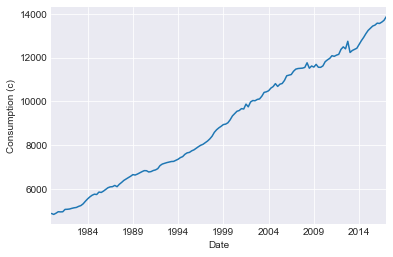

In [6]:
# However, our consumption data is non-stationary and this drives the previous
# estimate.
df.DPIC96.plot()
plt.xlabel('Date')
plt.ylabel('Consumption (c)')

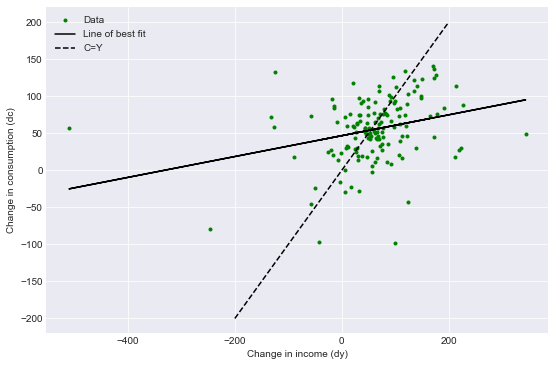

a_1 is 0.14075180213176142


In [7]:
# Lets use our second equation to try to find an estimate of a_1

df_diff = df.diff() #create dataframe of differenced values

# Plot the data
plt.figure(figsize=(9,6))
plt.plot(df_diff.DPIC96, df_diff.PCECC96, 'go', markersize=3.0, label = 'Data')
slope, intercept, r_value, p_value, std_err = stats.linregress(df_diff.DPIC96[1:], df_diff.PCECC96[1:]) # find line of best fit
plt.plot(df_diff.DPIC96[1:], intercept+slope*df_diff.DPIC96[1:], 'k-', label = 'Line of best fit')
plt.plot(np.array([-200, 200]), np.array([-200, 200]), 'k--', label = 'C=Y')
plt.xlabel('Change in income (dy)')
plt.ylabel('Change in consumption (dc)')
plt.legend()
plt.show()

print('a_1 is ' +  str(slope))

a_1 is now much lower, as we expected

### Household Data:

Cross-section plots of consumption and income: very large and significant $a_0$, $a_1$ maybe 0.5. <br>

Further facts:
1. Black households save more than whites at a given income level.<br>
0. By income group:
   * low-income: Implausibly large dissaving (spend 2 or 3 times income)
   * high-income: Remarkably high saving

### 2. Duesenberry

Habit formation may explain why $c_{t-1}$ affects $c_t$.<br>
Relative Income Hypothesis suggests that you compare your consumption to consumption of ‘peers’.<br>
May explain high saving rates of black HHs.<br>

Problems with Duesenberry: <br>
No budget constraint<br>
No serious treatment of intertemporal nature of saving

#### Dusenberry: Evidence

In [8]:
# Even if we control for income, past consumption seems to be significantly related to current consumption

df_habit = df.copy()
df_habit.columns = ['cons', 'inc']
df_habit['cons_m1'] = df.PCECC96.shift()
df_habit.dropna()

result = sm.ols(formula = "cons ~ inc + cons_m1", data=df_habit.dropna()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cons   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.613e+05
Date:                Fri, 30 Aug 2019   Prob (F-statistic):          1.33e-258
Time:                        17:18:23   Log-Likelihood:                -761.27
No. Observations:                 148   AIC:                             1529.
Df Residuals:                     145   BIC:                             1538.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.0236     15.017      0.601      0.549     -20.657      38.704
inc            0.0611      0.025      2.493      0.014       0.013       0.110
cons_m1        0.9371      0.026     35.527      0.000       0.885       0.989
==============================================================================
Omnibus:                       18.409   Durbin-Watson:                   1.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.989
Skew:                          -0.733   Prob(JB):                     6.18e-06
Kurtosis:                       4.320   Cond. No.                     5.48e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
# This regression is clearly problematic for the usual non-stationary reasons.
# Nevertheless we see that the coefficient on lagged consumption is very significant.

### 3. Friedman's Permanent Income Hypothesis

$$c = p + u$$
$$y = p + v$$

We can try to test this theory across households. If we run a regression of the form:
$$c_i = a_0 + a_{1}y_{i} + u_{i}$$

And if Friedman is correct, and the "true" coefficient on permanent income $p$ is 1, then the coefficient on $y$ will be:
$$a_1 = \frac{s^2_{p}}{(s^2_{v} + s^2_{p})}$$

#### Friedman's Permanent Income Hypothesis: HARK

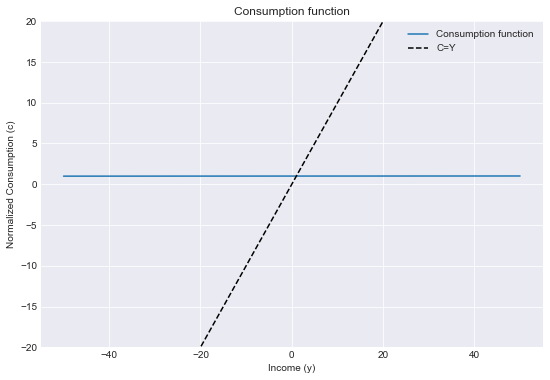

In [10]:
# We can get the PIH result with a specific parameterisation of our consumer that we used earlier
# for the Keynesian consumption function

PFexample_PIH = deepcopy(PFexample) #copy our last agent

# Change some parameters...
PFexample_PIH.DiscFac = 1.
PFexample_PIH.Rfree = 1.
PFexample_PIH.LivPrb = [1.0]
PFexample_PIH.PermGroFac = [1.0]

PFexample_PIH.solve() # solve the consumer's problem
PFexample_PIH.unpackcFunc() # unpack the consumption function

# Plot the perfect foresight consumption function
income_PF = np.linspace(-50, 50, 20) # pick some income points
plt.figure(figsize=(9,6))
plt.plot(income_PF, PFexample_PIH.solution[0].cFunc(income_PF), label = 'Consumption function') #plot income versus the consumption
plt.plot(income_PF, income_PF, 'k--', label = 'C=Y')
plt.title('Consumption function')
plt.xlabel('Income (y)')
plt.ylabel('Normalized Consumption (c)')
plt.ylim(-20, 20)
plt.legend()
plt.show()

In [11]:
# We can see that regardless of the income our agent recieves, they consume their permanent income, normalised to 1

We can also draw out some implications of the PIH that we can then test with evidence

If we look at HH's who have very similar permanent incomes, we should get a small estimate of $a_1$, because $s^2_v$ is large relative to $s^2_p$.

Lets simulate this using our HARK consumer.

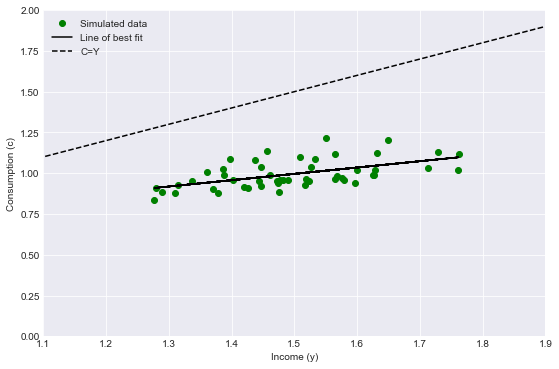

a_0 is 0.41397079625674804
a_1 is 0.38808227439834797


In [12]:
# Permanent income has low variance

perm_inc = np.random.normal(1., 0.1, 50)
trans_inc = np.random.normal(0.5, 0.1, 50)

total_inc = perm_inc + trans_inc

slope, intercept, r_value, p_value, std_err = stats.linregress(total_inc, PFexample_PIH.solution[0].cFunc(total_inc)*perm_inc)

plt.figure(figsize=(9,6))
plt.plot(total_inc, PFexample_PIH.solution[0].cFunc(total_inc)*perm_inc, 'go', label='Simulated data')
plt.plot(total_inc, intercept + slope*total_inc, 'k-', label='Line of best fit')
plt.plot(np.linspace(1, 2, 5), np.linspace(1, 2, 5), 'k--', label='C=Y')
plt.xlabel('Income (y)')
plt.ylabel('Consumption (c)')
plt.legend()
plt.ylim(0, 2)
plt.xlim(1.1, 1.9)
plt.show()

print('a_0 is ' + str(intercept))
print('a_1 is ' +  str(slope))

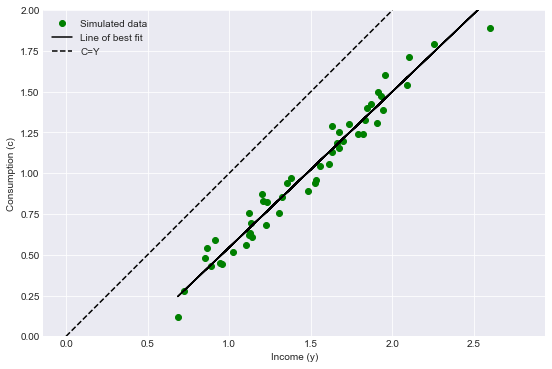

a_0 is -0.41020991815049723
a_1 is 0.9556042732938947


In [13]:
# Permanent income with higher variance

perm_inc = np.random.normal(1., 0.5, 50)
trans_inc = np.random.normal(0.5, 0.1, 50)

total_inc = perm_inc + trans_inc

slope, intercept, r_value, p_value, std_err = stats.linregress(total_inc, PFexample_PIH.solution[0].cFunc(total_inc)*perm_inc)

plt.figure(figsize=(9,6))
plt.plot(total_inc, PFexample_PIH.solution[0].cFunc(total_inc)*perm_inc, 'go', label='Simulated data')
plt.plot(total_inc, intercept + slope*total_inc, 'k-', label='Line of best fit')
plt.plot(np.linspace(0, 2, 5), np.linspace(0, 2, 5), 'k--', label='C=Y')
plt.xlabel('Income (y)')
plt.ylabel('Consumption (c)')
plt.legend()
plt.ylim(0, 2)
plt.show()

print('a_0 is ' + str(intercept))
print('a_1 is ' +  str(slope))

In [14]:
# We can see that as we increase the variance of permanent income, the estimate of a_1 rises

#### Friedman's Permanent Income Hypothesis: Evidence

We can now consider the empirical evidence for the claims our HARK model made about the PIH.

If we take a long time series, then the differences in permanent income should be the main driver of the variance in total income. This implies that a_1 should be high.

If we take higher frequency time series (or cross sectional data), transitory shocks should dominate, and our estimate of a_1 should be lower.

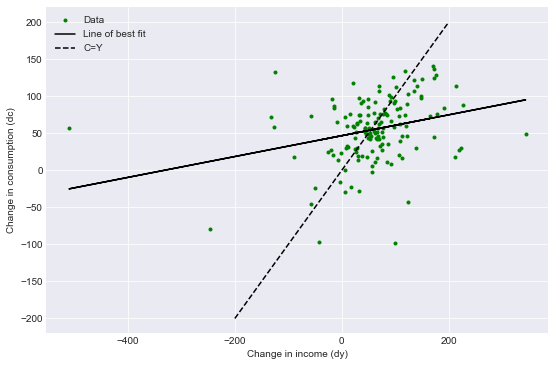

a_1 is 0.14075180213176142


In [15]:
# Lets use the data from FRED that we used before.

# Using quarterly data (copying from above), we had:

plt.figure(figsize=(9,6))
plt.plot(df_diff.DPIC96, df_diff.PCECC96, 'go', markersize=3.0, label = 'Data')
slope, intercept, r_value, p_value, std_err = stats.linregress(df_diff.DPIC96[1:], df_diff.PCECC96[1:]) # find line of best fit
plt.plot(df_diff.DPIC96[1:], intercept+slope*df_diff.DPIC96[1:], 'k-', label = 'Line of best fit')
plt.plot(np.array([-200, 200]), np.array([-200, 200]), 'k--', label = 'C=Y')
plt.xlabel('Change in income (dy)')
plt.ylabel('Change in consumption (dc)')
plt.legend()
plt.show()

print('a_1 is ' +  str(slope))

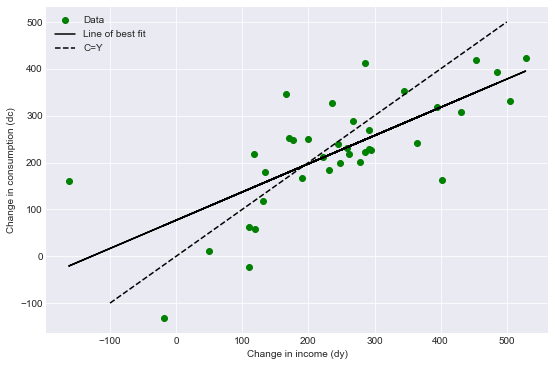

a_0 is 76.89850630442976
a_1 is 0.602260412659793


In [16]:
# Using annual data

sdt = dt.datetime(1980, 1, 1) #set startdate
edt = dt.datetime (2017, 1, 1) #set end date
df_an = web.DataReader(["PCECCA", "A067RX1A020NBEA"], "fred", sdt, edt) #import the annual data from Fred

df_an_diff = df_an.diff()
df_an_diff.columns = ['cons', 'inc']

plt.figure(figsize=(9,6))
plt.plot(df_an_diff.inc, df_an_diff.cons, 'go', label='Data')
slope, intercept, r_value, p_value, std_err = stats.linregress(df_an_diff.inc[1:], df_an_diff.cons[1:]) # find line of best fit
plt.plot(df_an_diff.inc[1:], intercept+slope*df_an_diff.inc[1:], 'k-', label='Line of best fit')
plt.plot(np.linspace(-100, 500, 3), np.linspace(-100, 500, 3), 'k--', label='C=Y')
plt.legend()
plt.xlabel('Change in income (dy)')
plt.ylabel('Change in consumption (dc)')
plt.show()

print('a_0 is ' + str(intercept))
print('a_1 is ' +  str(slope))

In [17]:
# The estimate of a_1 using the annual data is much higher because permanent income is playing a much more important role
# in explaining the variation in consumption.